## simcse

In [ ]:
!pip install simcse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.8 MB 1.6 MB/s 
     |████████████████████████████████| 5.8 MB 58.0 MB/s 
     |████████████████████████████████| 14.9 MB 288 kB/s 
     |████████████████████████████████| 7.6 MB 34.9 MB/s 
     |████████████████████████████████| 182 kB 54.7 MB/s 
  Created wheel for simcse: filename=simcse-0.4-py3-none-any.whl size=15032 sha256=48a639fca5bbaf5310682fdd5ee3a172e5219f0d406e5e013494562026d1b372
  Stored in directory: /root/.cache/pip/wheels/66/c7/a1/943dce343008edd2637cd262116d3a3e9ea3889fd47cec2ac2
Successfully built simcse
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolve

In [ ]:
from simcse import SimCSE
model = SimCSE("princeton-nlp/sup-simcse-bert-base-uncased")

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NLP_Projekt/IMDB Dataset.csv").iloc[:9000,:]

In [ ]:
X = df.iloc[:,0]
y = [0 if df.iloc[i,1]=='negative' else 1 for i in range(len(df.iloc[:,1]))]

In [ ]:
df.iloc[0:10,:]

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
X = df.iloc[:,0]
y = [0 if df.iloc[i,1]=='negative' else 1 for i in range(len(df.iloc[:,1]))]

In [ ]:
def simcse_voting(train_sizes=[10,20,30,40,50,75,100]):
    # single closest neighbor
    accuracies = []
    for train_size in train_sizes:
        train_size_acc = []
        for run in range(5):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1-train_size/9000), random_state=42)
            model_similarities = model.similarity(list(X_train), list(X_test))
            y_hat = []
            for i in range(model_similarities.shape[1]):
                y_hat.append(y_train[np.argmax(model_similarities[:,i])])
            train_size_acc.append(np.mean(np.array(y_hat) == np.array(y_test)))
        accuracies.append(np.mean(train_size_acc))
    return accuracies

In [ ]:
acc = simcse_voting()

100%|██████████| 140/140 [01:10<00:00,  1.99it/s]


In [ ]:
acc

[0.5634037819799778,
 0.6742761692650334,
 0.6820512820512821,
 0.6997767857142857,
 0.7084916201117318,
 0.6973669467787115,
 0.6939325842696629]

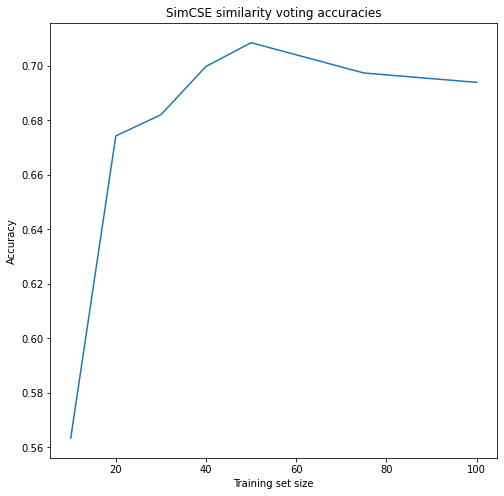

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(train_sizes, acc)
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("SimCSE similarity voting accuracies")
plt.show()

In [ ]:
def simcse_voting_mean(train_sizes=[100]):
    # average probbility over all training samples
    accuracies = []
    for train_size in train_sizes:
        train_size_acc = []
        for run in range(1):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1-train_size/9000), random_state=42)
            model_similarities = model.similarity(list(X_train), list(X_test))
            y_hat = []
            good_idx = np.where(np.array(y_train)==1)[0]
            bad_idx = np.where(np.array(y_train)==0)[0]
            for i in range(model_similarities.shape[1]):
                y_hat.append(int(np.mean([model_similarities[:,0][j] for j in good_idx]) > np.mean([model_similarities[:,0][j] for j in bad_idx])))
            train_size_acc.append(np.mean(np.array(y_hat) == np.array(y_test)))
        accuracies.append(np.mean(train_size_acc))
    return accuracies

In [ ]:
acc_mean = simcse_voting_mean()

100%|██████████| 140/140 [01:10<00:00,  1.97it/s]


In [ ]:
acc_mean

[0.49786516853932583]

In [ ]:
def simcse_voting_best_n(train_sizes=[10,20,30,40,50,60,70,80,90,100]):
    accuracies_1 = []
    accuracies_3 = []
    accuracies_5 = []
    accuracies_7 = []
    accuracies_9 = []
    f1_1, f1_3, f1_5, f1_7, f1_9 = [[],[],[],[],[]]
    for train_size in train_sizes:
        train_size_acc_1 = []
        train_size_acc_3 = []
        train_size_acc_5 = []
        train_size_acc_7 = []
        train_size_acc_9 = []
        train_f1_1, train_f1_3, train_f1_5, train_f1_7, train_f1_9 = [[],[],[],[],[]]
        for run in range(5):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1-train_size/9000), random_state=42)
            model_similarities = model.similarity(list(X_train), list(X_test))
            y_hat_1 = []
            y_hat_3 = []
            y_hat_5 = []
            y_hat_7 = []
            y_hat_9 = []
            for i in range(model_similarities.shape[1]):
                if np.sum([y_train[j] for j in np.argpartition(model_similarities[:,i], -1)[-1:]]) > 0:
                    y_hat_1.append(1)
                else:
                    y_hat_1.append(0)
                if np.sum([y_train[j] for j in np.argpartition(model_similarities[:,i], -3)[-3:]]) > 1:
                    y_hat_3.append(1)
                else:
                    y_hat_3.append(0)
                if np.sum([y_train[j] for j in np.argpartition(model_similarities[:,i], -5)[-5:]]) > 2:
                    y_hat_5.append(1)
                else:
                    y_hat_5.append(0)
                if np.sum([y_train[j] for j in np.argpartition(model_similarities[:,i], -7)[-7:]]) > 3:
                    y_hat_7.append(1)
                else:
                    y_hat_7.append(0)
                if np.sum([y_train[j] for j in np.argpartition(model_similarities[:,i], -9)[-9:]]) > 4:
                    y_hat_9.append(1)
                else:
                    y_hat_9.append(0)
            train_size_acc_1.append(np.mean(np.array(y_hat_1) == np.array(y_test)))
            train_size_acc_3.append(np.mean(np.array(y_hat_3) == np.array(y_test)))
            train_size_acc_5.append(np.mean(np.array(y_hat_5) == np.array(y_test)))
            train_size_acc_7.append(np.mean(np.array(y_hat_7) == np.array(y_test)))
            train_size_acc_9.append(np.mean(np.array(y_hat_9) == np.array(y_test)))

            train_f1_1.append(f1_score(y_test, y_hat_1))
            train_f1_3.append(f1_score(y_test, y_hat_3))
            train_f1_5.append(f1_score(y_test, y_hat_5))
            train_f1_7.append(f1_score(y_test, y_hat_7))
            train_f1_9.append(f1_score(y_test, y_hat_9))
        accuracies_1.append(np.mean(train_size_acc_1))
        accuracies_3.append(np.mean(train_size_acc_3))
        accuracies_5.append(np.mean(train_size_acc_5))
        accuracies_7.append(np.mean(train_size_acc_7))
        accuracies_9.append(np.mean(train_size_acc_9))
        f1_1.append(np.mean(train_f1_1))
        f1_3.append(np.mean(train_f1_3))
        f1_5.append(np.mean(train_f1_5))
        f1_7.append(np.mean(train_f1_7))
        f1_9.append(np.mean(train_f1_9))
    return [[accuracies_1, accuracies_3, accuracies_5, accuracies_7, accuracies_9], [f1_1, f1_3, f1_5, f1_7, f1_9]]

In [ ]:
train_sizes=[10,20,30,40,50,60,70,80,90,100]

In [ ]:
test_scores = simcse_voting_best_n(train_sizes=train_sizes)

100%|██████████| 140/140 [01:11<00:00,  1.97it/s]


In [ ]:
test_acc = test_scores[0]
test_f1 = test_scores[1]

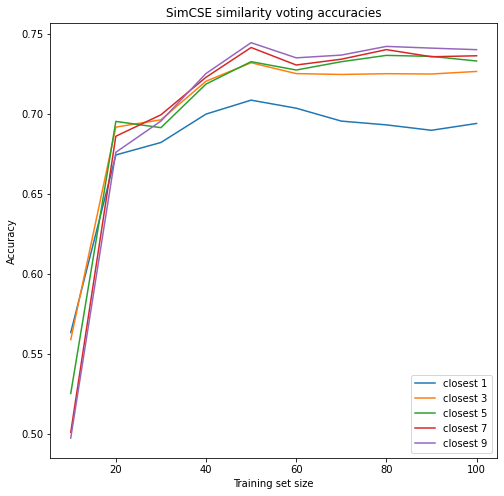

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(train_sizes, test_acc[0])
plt.plot(train_sizes, test_acc[1])
plt.plot(train_sizes, test_acc[2])
plt.plot(train_sizes, test_acc[3])
plt.plot(train_sizes, test_acc[4])
plt.legend(["closest 1", "closest 3", "closest 5", "closest 7", "closest 9"], loc=4)
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("SimCSE similarity voting accuracies")
plt.show()

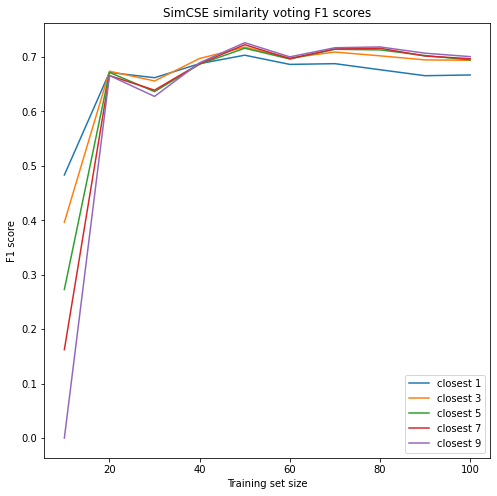

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(train_sizes, test_f1[0])
plt.plot(train_sizes, test_f1[1])
plt.plot(train_sizes, test_f1[2])
plt.plot(train_sizes, test_f1[3])
plt.plot(train_sizes, test_f1[4])
plt.legend(["closest 1", "closest 3", "closest 5", "closest 7", "closest 9"])
plt.xlabel("Training set size")
plt.ylabel("F1 score")
plt.title("SimCSE similarity voting F1 scores")
plt.show()